In [1]:
include("../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots, UnicodePlots
using OrdinaryDiffEq
using DelimitedFiles
const ODE = OrdinaryDiffEq

OrdinaryDiffEq

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 500
quadrature_order       = 2
nevs                   = 20
topk                   = 3
ϵ                      = 0.025
num_steps              = 20
t_initial              = minimum(Time)
t_end                  = t_initial+60     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30;

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = ODE.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=1e-10, solver=OrdinaryDiffEq.BS5())[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
ctx, _ = regularTriangularGrid((grid_resolution, Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_transfer_function_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
nothing

913.189925 seconds (169.93 M allocations: 10.138 GiB, 0.20% gc time)


In [10]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=20, which=:SM);

In [11]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_transfer_function_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
    DTminusϵ(x) = linearized_transfer_function_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

905.046751 seconds (134.80 M allocations: 7.877 GiB, 0.10% gc time)
909.272801 seconds (134.57 M allocations: 7.866 GiB, 0.10% gc time)
1/10
903.367880 seconds (122.05 M allocations: 7.332 GiB, 0.12% gc time)
906.179752 seconds (122.05 M allocations: 7.332 GiB, 0.08% gc time)
2/10
902.105831 seconds (122.05 M allocations: 7.332 GiB, 0.12% gc time)
905.483776 seconds (122.05 M allocations: 7.332 GiB, 0.08% gc time)
3/10
900.790872 seconds (122.05 M allocations: 7.332 GiB, 0.12% gc time)
904.755081 seconds (122.05 M allocations: 7.332 GiB, 0.08% gc time)
4/10
900.599084 seconds (122.05 M allocations: 7.332 GiB, 0.12% gc time)
904.925155 seconds (122.05 M allocations: 7.332 GiB, 0.08% gc time)
5/10
900.350105 seconds (122.05 M allocations: 7.332 GiB, 0.12% gc time)
904.497151 seconds (122.05 M allocations: 7.332 GiB, 0.08% gc time)
6/10
900.317564 seconds (122.05 M allocations: 7.332 GiB, 0.12% gc time)
904.573874 seconds (122.05 M allocations: 7.332 GiB, 0.08% gc time)
7/10
899.958419 se

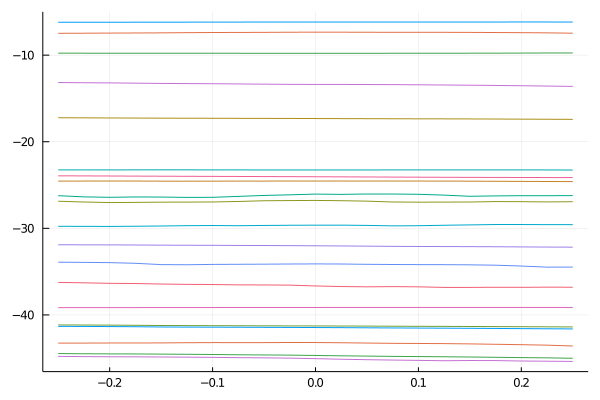

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

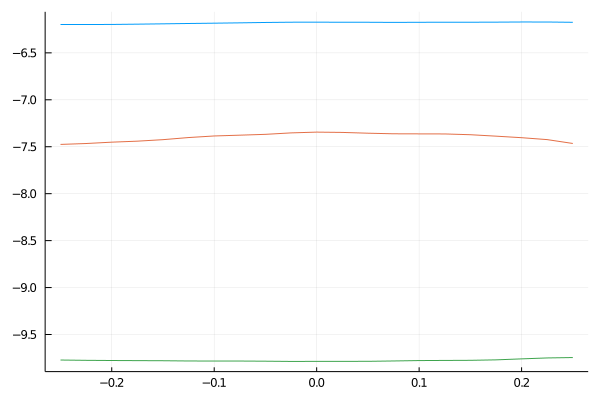

In [13]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1:topk], legend=false, fmt = :png)

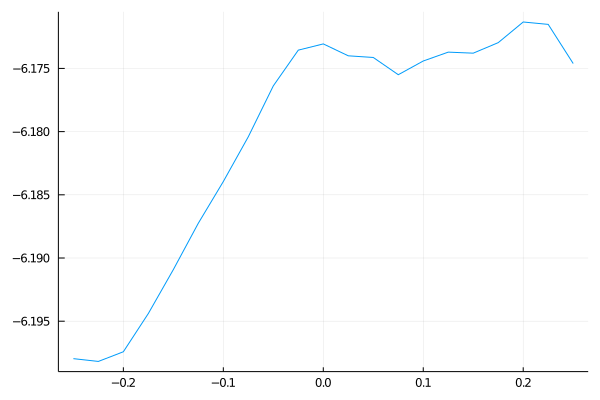

In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1], legend=false, fmt = :png)

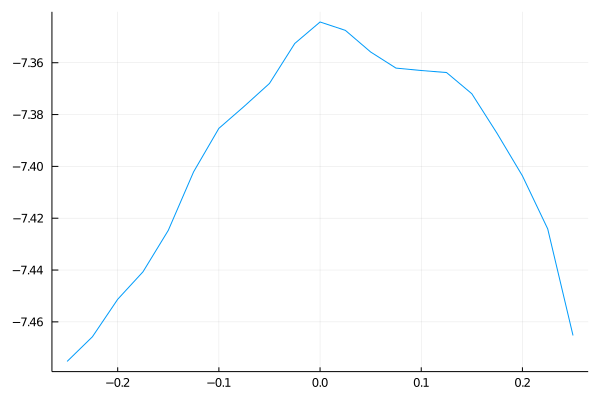

In [15]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

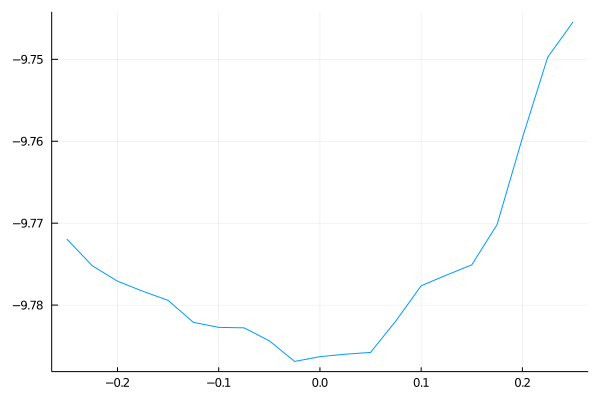

In [16]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,3], legend=false, fmt = :png)

In [17]:
[range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs]

21×21 Array{Float64,2}:
 -0.25   -6.19796  -7.47527  -9.77194  …  -43.2533  -44.4587  -44.7855
 -0.225  -6.19818  -7.46575  -9.77519     -43.2517  -44.4847  -44.8136
 -0.2    -6.19742  -7.45129  -9.77708     -43.2413  -44.499   -44.8316
 -0.175  -6.19439  -7.44067  -9.77831     -43.2404  -44.5054  -44.8403
 -0.15   -6.19092  -7.42468  -9.77943     -43.2314  -44.5245  -44.8596
 -0.125  -6.18725  -7.40211  -9.78211  …  -43.2088  -44.544   -44.8794
 -0.1    -6.18395  -7.38532  -9.78272     -43.1959  -44.5696  -44.9008
 -0.075  -6.1804   -7.37682  -9.78278     -43.1967  -44.6018  -44.9343
 -0.05   -6.17638  -7.36799  -9.78437     -43.1964  -44.6212  -44.9566
 -0.025  -6.17355  -7.35256  -9.78688     -43.1841  -44.6431  -44.9912
  0.0    -6.17306  -7.34428  -9.78629  …  -43.1875  -44.6815  -45.0479
  0.025  -6.174    -7.34751  -9.78599     -43.2129  -44.7219  -45.1164
  0.05   -6.17413  -7.35586  -9.78578     -43.2476  -44.7536  -45.1694
  0.075  -6.1755   -7.36207  -9.78193     -43.2803  -

In [18]:
evs

21×20 Array{Float64,2}:
 -6.19796  -7.47527  -9.77194  -13.1594  …  -43.2533  -44.4587  -44.7855
 -6.19818  -7.46575  -9.77519  -13.1861     -43.2517  -44.4847  -44.8136
 -6.19742  -7.45129  -9.77708  -13.2054     -43.2413  -44.499   -44.8316
 -6.19439  -7.44067  -9.77831  -13.2333     -43.2404  -44.5054  -44.8403
 -6.19092  -7.42468  -9.77943  -13.2661     -43.2314  -44.5245  -44.8596
 -6.18725  -7.40211  -9.78211  -13.2844  …  -43.2088  -44.544   -44.8794
 -6.18395  -7.38532  -9.78272  -13.2995     -43.1959  -44.5696  -44.9008
 -6.1804   -7.37682  -9.78278  -13.3241     -43.1967  -44.6018  -44.9343
 -6.17638  -7.36799  -9.78437  -13.3503     -43.1964  -44.6212  -44.9566
 -6.17355  -7.35256  -9.78688  -13.3716     -43.1841  -44.6431  -44.9912
 -6.17306  -7.34428  -9.78629  -13.3823  …  -43.1875  -44.6815  -45.0479
 -6.174    -7.34751  -9.78599  -13.3832     -43.2129  -44.7219  -45.1164
 -6.17413  -7.35586  -9.78578  -13.3913     -43.2476  -44.7536  -45.1694
 -6.1755   -7.36207  -9.781

In [19]:
writedlm("D:/"*string(grid_resolution)*"_"*string(Integer(num_steps/2)*ϵ)*"_"*string(t_end-t_initial)*".csv", [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")